# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import sys
print("Python %s" % sys.version)
import random
from collections import namedtuple, deque

Python 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [2]:
import numpy as np
print("NumPy %s" % np.__version__)

NumPy 1.16.5


In [3]:
import torch
print("PyTorch %s" % torch.__version__)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

PyTorch 1.2.0


In [4]:
import matplotlib
print("matplotlib %s" % matplotlib.__version__)
import matplotlib.pyplot as plt

# Set plotting options
%matplotlib inline

matplotlib 3.1.1


In [5]:
from unityagents import UnityEnvironment

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [6]:
env = UnityEnvironment(file_name="./Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [7]:
env.brain_names

['BananaBrain']

In [8]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [9]:
brain_name

'BananaBrain'

In [10]:
brain

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [11]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [12]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [13]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

### Q-Networks

In [14]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, 
                 fc1_units=512, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Fully connected layer 1
            fc2_units (int): Fully connected layer 2
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Agent

In [15]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed, device):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
            device (torch.device): - (type='cuda', index=0) for GPU 0
                                   - (type='cpu') for CPU
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", 
                                     field_names=["state", "action", "reward", 
                                                  "next_state", "done"])
        self.seed = random.seed(seed)
        self.device = device
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack(
            [e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack(
            [e.action for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack(
            [e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack(
            [e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack(
            [e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

Deep Q-Learning Algorithm$^{[1]}$

![deep-q-learning-algorithm](./images/deep-q-learning-algorithm.png)

In [16]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed, device):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
            device (torch.device): - (type='cuda', index=0) for GPU 0
                                   - (type='cpu') for CPU
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.device = device

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(self.device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(self.device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed, 
                                   self.device)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        ## TODO: compute and minimize the loss
        "*** YOUR CODE HERE ***"
        Q_targets = \
            rewards + \
            (gamma * \
             self.qnetwork_target(next_states).detach().max(dim=1).values.unsqueeze(1) * \
             (1 - dones))
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), 
                                             local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [17]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print("Use CUDA:",  use_cuda)

Use CUDA: True


In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [19]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

In [20]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, device=device)

In [21]:
agent.qnetwork_local

QNetwork(
  (fc1): Linear(in_features=37, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)

### Training

Episode 100	Average Score: 1.46
Episode 200	Average Score: 4.36
Episode 300	Average Score: 6.62
Episode 400	Average Score: 9.80
Episode 500	Average Score: 12.27
Episode 573	Average Score: 13.00
Environment solved in 473 episodes!	Average Score: 13.00


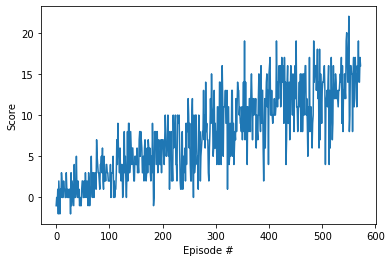

In [30]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            score += reward
            state = next_state
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(
              i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(
                  i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(
                  i_episode-100, np.mean(scores_window)))
            # use different method of saving below
            # torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

```
while sleep 0.2; do
nvidia-smi --query-gpu=name,index,temperature.gpu,\
utilization.gpu,utilization.memory,\
memory.total,memory.free,memory.used --format=csv,noheader
done
```

```
GeForce GTX 1060, 0, 63, 20 %, 6 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 21 %, 7 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 18 %, 6 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 19 %, 6 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 27 %, 7 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 26 %, 7 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 27 %, 8 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 25 %, 8 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 27 %, 8 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 22 %, 7 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 20 %, 7 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 21 %, 6 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 19 %, 7 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 19 %, 7 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 26 %, 7 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 27 %, 8 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 28 %, 8 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 26 %, 8 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 26 %, 8 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 21 %, 7 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 20 %, 7 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 20 %, 6 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 19 %, 6 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 18 %, 6 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 21 %, 7 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 20 %, 7 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 19 %, 6 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 19 %, 7 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 20 %, 7 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 21 %, 7 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 20 %, 7 %, 6078 MiB, 4580 MiB, 1498 MiB
GeForce GTX 1060, 0, 63, 20 %, 7 %, 6078 MiB, 4580 MiB, 1498 MiB
```

Save model.

In [34]:
checkpoint = {'state_size': state_size,
              'action_size': action_size,
              'fc1_units': 512,
              'fc2_units': 64,
              'state_dict': agent.qnetwork_local.state_dict()}

torch.save(checkpoint, './models/checkpoint.pth')

In [55]:
env.close()

### Agent in Action

In [22]:
def load_checkpoint(filepath, device):
    checkpoint = torch.load(filepath)
    qnetwork = QNetwork(state_size=checkpoint['state_size'], 
                        action_size=checkpoint['action_size'], 
                        seed=0,
                        fc1_units=checkpoint['fc1_units'],
                        fc2_units=checkpoint['fc2_units']).to(device)
    qnetwork.load_state_dict(checkpoint['state_dict'])
    
    return qnetwork

In [23]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print("Use CUDA:",  use_cuda)

Use CUDA: True


In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [25]:
qnetwork = load_checkpoint('./models/checkpoint.pth', device)
qnetwork.eval()

QNetwork(
  (fc1): Linear(in_features=37, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)

In [26]:
agent.qnetwork_local = qnetwork
agent.qnetwork_target = qnetwork

In [27]:
env = UnityEnvironment(file_name="./Banana_Linux/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [28]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = agent.act(state, eps=0.1)                 # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 13.0


Record the action in mp4 format.

In [30]:
%%bash
ls -l ./results/mp4

total 4460
-rw-rw-r-- 1 eka eka 4564539 Sep 25 21:02 01.mp4


Convert the mp4 to GIF.

In [34]:
%%bash
ffmpeg -ss 2 -i ./results/mp4/01.mp4 -vf "fps=10,scale=640:-1:flags=lanczos,split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse" ./results/gif/01.gif

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [53]:
env.close()

### Hardware Specifications and Software Versions

In [35]:
%%bash
cat /etc/os-release

NAME="Ubuntu"
VERSION="18.04.3 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.3 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


In [36]:
%%bash
nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [41]:
%%bash
nvidia-smi

Wed Sep 25 21:16:38 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1060    Off  | 00000000:01:00.0  On |                  N/A |
| N/A   58C    P3    23W /  N/A |   1455MiB /  6078MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [42]:
%%bash
pip freeze

absl-py==0.8.0
alabaster==0.7.12
anaconda-client==1.7.2
anaconda-project==0.8.3
asn1crypto==0.24.0
astor==0.7.1
astroid==2.2.5
astropy==3.2.1
atomicwrites==1.3.0
attrs==19.1.0
Babel==2.7.0
backcall==0.1.0
backports.os==0.1.1
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.8.0
bitarray==1.0.1
bkcharts==0.2
bleach==3.1.0
bokeh==1.3.4
boto==2.49.0
Bottleneck==1.2.1
certifi==2019.9.11
cffi==1.12.3
chardet==3.0.4
Click==7.0
cloudpickle==1.2.2
clyent==1.2.2
colorama==0.4.1
contextlib2==0.5.5
cryptography==2.7
cycler==0.10.0
Cython==0.29.13
cytoolz==0.10.0
dask==2.3.0
decorator==4.4.0
defusedxml==0.6.0
distributed==2.3.2
docopt==0.6.2
docutils==0.15.2
entrypoints==0.3
et-xmlfile==1.0.1
fastcache==1.1.0
Flask==1.1.1
fsspec==0.4.0
gast==0.2.0
gevent==1.4.0
gmpy2==2.0.8
google-pasta==0.1.7
greenlet==0.4.15
grpcio==1.11.0
h5py==2.9.0
heapdict==1.0.0
html5lib==0.9999999
idna==2.8
imageio==2.5.0
imagesize==1.1.0
importlib-metadata==0.19
ipykernel==5.1.2
ipython==7.8.0
ipython-genutils==

### References

`[1]` Udacity. *Deep Q-Learning Algorithm*. Deep Reinforcement Learning for Enterprise Nanodegree Program, Part 2, Lesson 2. 2019.